# Aereal data to hex

This notebook __creates tables 'hex_aereal_res{res}.gpkg'__, used in notebooks that calculate HQSL and notebook aux17.

## Import libraries

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import sys
module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/edgaregurrola/Repos/observatorio-ciudades/accesibilidad-urbana/aup/data.py:24: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(


## Config notebook

In [2]:
import h3
def neighbour_mean(hex_id, hex_id_name, hex_bins, col_name):
    return hex_bins.loc[hex_bins[hex_id_name].isin(h3.k_ring(hex_id,1)),col_name].mean()

In [3]:
# 'alex' or 'edgar'
all_local_dirs = 'edgar'
# Output hexs resolution           
res = 9
# save output to local?
save = True

In [4]:
if all_local_dirs == 'alex':
    grl_dir = "../../../data/processed/santiago/areal_data/"
    count_pois_dir = "../../../data/external/temporal_fromjupyter/santiago/pois/"
    ndvi_dir = "../../../data/external/temporal_todocker/santiago/ndvi_santiago/"
elif all_local_dirs == 'edgar':
    grl_dir = "../../../data/processed/00_pois_formated/aereal_data/"
    count_pois_dir = grl_dir
    ndvi_dir = grl_dir
else:
    print("WARNING: Fix all_local_dirs variable")

## Create hexgrid from area of interest

In [5]:
area_dict = {'unidadesvecinales':'COD_UNICO_',
            'zonascensales':'GEOCODI',
            'alameda':'name',
            'comunas':'Comuna',
            'hex':'hex_id',
            'santiago':'nom_region'}

In [6]:
area_analysis = 'hex' # unidadesvecinales, zonascensales, alameda, comunas
code_column = area_dict[area_analysis] # COD_UNICO_ - GEOCODI , name, Comuna

In [7]:
if area_analysis == 'unidadesvecinales':
    gdf = gpd.read_file('../../../data/processed/santiago/santiago_unidadesvecinales_zonaurbana.geojson')
    gdf = gdf[[code_column,'geometry']].copy()
    
elif area_analysis == 'zonascensales':
    gdf = gpd.read_file('../../../data/processed/santiago/santiago_zonascensalesanalysis_4_5_kmh.geojson')
    gdf = gdf[['GEOCODI','geometry']].copy()
    
elif area_analysis == 'alameda':
    gdf = gpd.read_file('../../../data/processed/santiago/alameda_all_buffer800m_gcs_v1.geojson')
    gdf = gdf[[code_column,'geometry']].copy()
    
elif area_analysis == 'comunas':
    gdf = gpd.read_file('../../../data/processed/santiago/santiago_comunas_zonaurbana.geojson')
    gdf = gdf[[code_column,'geometry']].copy()

elif area_analysis == 'santiago':
    gdf = gpd.read_file('../../../data/processed/santiago/zonaurbana_zonascensales.gpkg')
    gdf = gdf[[code_column,'geometry']].copy()

elif area_analysis == 'hex':
    query = 'SELECT * FROM projects_research.santiago_aoi'
    aoi = aup.gdf_from_query(query)
    
    # When working without internet connection:
    #aoi = gpd.read_file("../../../data/processed/santiago/santiago_aoi.gpkg")
    #aoi = gpd.read_file("../../../data/external/temporal_todocker/santiago/proximidad/santiago_odc_aoi_32719.gpkg")
    
    try:
        aoi = aoi.set_crs("EPSG:4326")
    except:
        aoi = aoi.to_crs("EPSG:4326")
    
    gdf = aup.create_hexgrid(aoi, res)
    
    gdf.rename(columns={f'hex_id_{res}':'hex_id'},inplace=True)


gdf = gdf.explode(ignore_index=True)
gdf = gdf.loc[~((gdf.to_crs("EPSG:32719").area/10000)<0.5)]
gdf = gdf.dissolve(by=code_column)
gdf = gdf.reset_index()

print(gdf.shape)
gdf.head(2)

(30073, 2)


,hex_id,geometry
0,89b2c0b0003ffff,"POLYGON ((-71.00923 -33.71126, -71.01041 -33.7..."
1,89b2c0b0007ffff,"POLYGON ((-71.00625 -33.71263, -71.00742 -33.7..."


<AxesSubplot: >

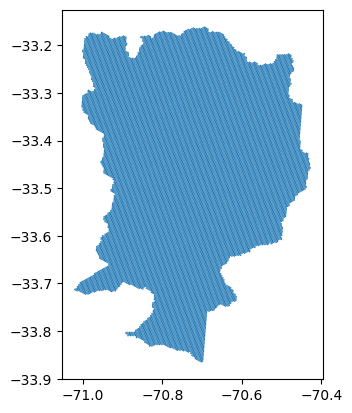

In [8]:
gdf.plot()

## __Housing__

### __Housing__ - Load data

In [9]:
viv_nodes = gpd.read_file(count_pois_dir + 'casas_deptos_mzn.gpkg')
viv_nodes = viv_nodes[['osmid','total_viv','geometry']]
viv_nodes = viv_nodes.rename(columns={'total_viv':'viv_sum'})
# Show
print(viv_nodes.shape)
viv_nodes.head(2)

(214430, 3)


,osmid,viv_sum,geometry
0,14609420,20.126666,POINT (-70.75478 -33.51598)
1,266255164,21.028271,POINT (-70.79327 -33.52609)


### __Housing__ - Sum all viv by hexagon

In [10]:
viv_hexs = gpd.sjoin(viv_nodes, gdf)
grouped_by = viv_hexs.groupby(code_column).agg({'viv_sum':np.sum})
viv_gdf = grouped_by.reset_index().copy()
viv_tot = viv_gdf.copy()

# calcuate density
viv_gdf = gdf.merge(viv_gdf, on=code_column)
viv_gdf['viv_sum'] = viv_gdf['viv_sum'] / (viv_gdf.to_crs("EPSG:32719").area/10000)
viv_gdf = viv_gdf.drop(columns='geometry')
# Show
print(viv_gdf.shape)
print(f"NaNs in viv_sum: {viv_gdf.loc[viv_gdf.viv_sum.isna()].shape[0]}.")
viv_gdf.head(2)

(10105, 2)
NaNs in viv_sum: 0.


,hex_id,viv_sum
0,89b2c0b00d7ffff,2.086578e-08
1,89b2c0b0427ffff,8.541227e-08


## __Social housing__

### __Social housing__ - Load data

In [11]:
socviv_nodes = gpd.read_file(count_pois_dir + 'viv_social.gpkg')
socviv_nodes = socviv_nodes.rename(columns={'housing':'viv_social_count'})
# Show
print(socviv_nodes.shape)
socviv_nodes.head(2)

(34639, 3)


,osmid,viv_social_count,geometry
0,14528355,0.662426,POINT (-70.69014 -33.45685)
1,14805060,1.897061,POINT (-70.58526 -33.47253)


### __Social housing__ - Calculate percentage of viv that belong to social housing by hex

In [12]:
# Sum social housing by hex
socviv_hex = gpd.sjoin(socviv_nodes, gdf)
grouped_by = socviv_hex.groupby(code_column).agg({'viv_social_count':np.sum})
socviv_gdf = grouped_by.reset_index().copy()

# Merge with previously calculated viv_hex
both_viv_gdf = pd.merge(viv_tot,socviv_gdf,on=code_column, how='outer')
# Fill NaNs in social viv with 0s and 
both_viv_gdf['viv_social_count'].fillna(0,inplace=True)
# Calculate pct of viv that are social viv
both_viv_gdf['pct_social_viv'] = (both_viv_gdf['viv_social_count'] / both_viv_gdf['viv_sum'])*100

# Filter and format
both_viv_gdf = both_viv_gdf[[code_column,'viv_sum','pct_social_viv']]

# Drop pct_social_viv NaNs (0/0 or NaN/something)
print(f"NaNs in pct_social_viv: {both_viv_gdf.loc[both_viv_gdf.pct_social_viv.isna()].shape[0]}.")
both_viv_gdf.dropna(subset = ["pct_social_viv"], inplace=True)
print(f"NaNs in pct_social_viv: {both_viv_gdf.loc[both_viv_gdf.pct_social_viv.isna()].shape[0]}.")

# join processed data
both_viv_gdf = both_viv_gdf.drop(columns=['viv_sum'])
both_viv_gdf = both_viv_gdf.merge(viv_gdf, on=code_column)


# Show
print(both_viv_gdf.shape)
both_viv_gdf.head(2)

NaNs in pct_social_viv: 31.
NaNs in pct_social_viv: 0.
(10076, 3)


,hex_id,pct_social_viv,viv_sum
0,89b2c0b00d7ffff,0.0,2.086578e-08
1,89b2c0b0427ffff,0.0,8.541227e-08


## __Hotels__

### __Hotels__ - Load usos de suelo data

In [13]:
# Load node data
uso_suelo_nodes = gpd.read_file(count_pois_dir + 'usos_de_suelo.gpkg')

# Calculate total area by node
all_uses = ['ADMIN','AGR','BBCC','BODEG','COM','CULT','DEPOR','EDUC','ERIAZO',
            'ESTAC','HABIT','HOTEL','INDUS','MIN','OFIC','OTROS','SALUD','TPTE']
uso_suelo_nodes['tot_area'] = uso_suelo_nodes[all_uses].sum(axis=1)

# Show
print(uso_suelo_nodes.shape)
uso_suelo_nodes.head(2)

(229965, 21)


,osmid,ADMIN,AGR,BBCC,BODEG,COM,CULT,DEPOR,EDUC,ERIAZO,...,HABIT,HOTEL,INDUS,MIN,OFIC,OTROS,SALUD,TPTE,geometry,tot_area
0,386139,0.0,0.0,0.520425,163.909199,769.964416,27.715437,0.0,13.781373,0.0,...,203.073595,14.213205,0.107459,0.0,887.353986,30.780062,0.199923,0.0,POINT (-70.64725 -33.44313),2111.619078
1,386140,0.0,0.0,0.000000,0.114390,0.532323,0.000000,0.0,0.000000,0.0,...,0.130597,0.000000,0.000000,0.0,0.618872,0.021155,0.000000,0.0,POINT (-70.64767 -33.44304),1.417338


### __Hotels__ - Calculate built percentage that belongs to hotels

In [14]:
# Sum all data (all usos de suelo) by hex
uso_suelo_hex = gpd.sjoin(uso_suelo_nodes, gdf)
grouped_by = uso_suelo_hex.groupby(code_column).agg({'HOTEL':np.sum,'tot_area':np.sum})
uso_suelo_gdf = grouped_by.reset_index().copy()

# Calculate percentage of total area that belongs to hotels by hex
uso_suelo_gdf['pct_hotel'] = (uso_suelo_gdf['HOTEL']/uso_suelo_gdf['tot_area'])*100

# Filter and format
hotel_gdf = uso_suelo_gdf[[code_column,'pct_hotel']].copy()

# Drop pct_hotel NaNs (0/0 or NaN/something)
print(f"NaNs in pct_hotel: {hotel_gdf.loc[hotel_gdf.pct_hotel.isna()].shape[0]}.")
hotel_gdf.fillna(0, inplace=True)
print(f"NaNs in pct_hotel: {hotel_gdf.loc[hotel_gdf.pct_hotel.isna()].shape[0]}.")

# Show
print(hotel_gdf.shape)
hotel_gdf.head(2)

NaNs in pct_hotel: 1021.
NaNs in pct_hotel: 0.
(13855, 2)


,hex_id,pct_hotel
0,89b2c0b0083ffff,0.0
1,89b2c0b0087ffff,0.0


## __NDVI__

### __NDVI__ - Load data (Already processed to hexs)

In [15]:
ndvi_gdf = gpd.read_file(ndvi_dir + f'Santiago_ndvi_HexRes{res}_v0.geojson')

# Show
print(ndvi_gdf.shape)
ndvi_gdf.head(2)

(9170, 11)


,hex_id,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,city,geometry
0,89b2c55085bffff,9,0.018576,0.010166,0.015034,0.028624,0.005130,0.023493,-0.000404,Santiago,"POLYGON ((-70.79572 -33.40004, -70.79689 -33.4..."
1,89b2c509dc7ffff,9,0.302082,0.166934,0.247760,0.639392,0.114962,0.524430,-0.000667,Santiago,"POLYGON ((-70.53795 -33.53054, -70.53912 -33.5..."


### NDVI - Translate to polygon

In [16]:
if area_analysis != 'hex':
    ndvi_poly = gpd.sjoin(ndvi_gdf[['ndvi_mean','geometry']], gdf)
    grouped_by = ndvi_poly.groupby(code_column).agg({'ndvi_mean':np.mean})
    ndvi_gdf = grouped_by.reset_index().copy()
elif area_analysis == 'hex':
    ndvi_gdf = ndvi_gdf[['hex_id','ndvi_mean']]
    
# Show
print(ndvi_gdf.shape)
print(f"NaNs in viv_sum: {ndvi_gdf.loc[ndvi_gdf.ndvi_mean.isna()].shape[0]}.")
ndvi_gdf.head(2)

(9170, 2)
NaNs in viv_sum: 0.


,hex_id,ndvi_mean
0,89b2c55085bffff,0.018576
1,89b2c509dc7ffff,0.302082


## __Offices__

### __Offices__ - Load data

In [17]:
oficina_nodes = gpd.read_file(count_pois_dir + 'oficinas.gpkg')
oficina_nodes = oficina_nodes.rename(columns={'Oficinas':'oficinas_sum'})
# Show
print(oficina_nodes.shape)
oficina_nodes.head(2)

(229965, 3)


,osmid,oficinas_sum,geometry
0,386139,12.820194,POINT (-70.64725 -33.44313)
1,386140,0.008953,POINT (-70.64767 -33.44304)


### __Offices__ - Sum all offices by hexagon

In [18]:
oficina_hexs = gpd.sjoin(oficina_nodes, gdf)
grouped_by = oficina_hexs.groupby(code_column).agg({'oficinas_sum':np.sum})
oficina_gdf = grouped_by.reset_index().copy()

# calcuate density
oficina_gdf = gdf.merge(oficina_gdf, on=code_column)
oficina_gdf['oficinas_sum'] = oficina_gdf['oficinas_sum'] / (oficina_gdf.to_crs("EPSG:32719").area/10000)
oficina_gdf = oficina_gdf.drop(columns='geometry')

# Show
print(oficina_gdf.shape)
print(f"NaNs in oficinas_sum: {oficina_gdf.loc[oficina_gdf.oficinas_sum.isna()].shape[0]}.")
oficina_gdf.head(2)

(13855, 2)
NaNs in oficinas_sum: 0.


,hex_id,oficinas_sum
0,89b2c0b0083ffff,0.031580
1,89b2c0b0087ffff,0.005063


In [19]:
oficina_gdf.oficinas_sum.mean()

0.6443416424856647

## Noise

### Noise - load data

In [20]:
noise_gdf = gpd.read_file(count_pois_dir + 'noise_map.gpkg')
noise_gdf['noise_count'] = (noise_gdf['db_hi'] + noise_gdf['db_lo']) / 2
# Show
print(noise_gdf.shape)
noise_gdf.head(2)

(398, 11)


,objectid,cod_region,nom_region,db_lo,db_hi,shape_st_a,shape_st_l,st_area_sh,st_length_,geometry,noise_count
0,1,13,Metropolitana de Santiago,35.0,40.0,148.017871,242.675290,148.017871,242.675290,"MULTIPOLYGON (((-70.71167 -33.48831, -70.71178...",37.5
1,2,13,Metropolitana de Santiago,40.0,45.0,8978.943460,6995.965866,8978.943460,6995.965866,"MULTIPOLYGON (((-70.70945 -33.49508, -70.70837...",42.5


### Noise - data to hex

In [21]:
noise_gdf = noise_gdf.explode().reset_index().drop(columns=['level_0','level_1'])[['noise_count','geometry']]
# Sum social housing by hex
noise_hex = gpd.sjoin(noise_gdf, gdf)
grouped_by = noise_hex.groupby(code_column).agg({'noise_count':np.mean})
hex_noise = grouped_by.reset_index().copy()

hex_noise.loc[np.isnan(noise_gdf.noise_count), 'noise_count'] = hex_noise.loc[np.isnan(noise_gdf.noise_count)].apply(lambda x: neighbour_mean(x['hex_id'],
                                                                            'hex_id',
                                                                            hex_noise,
                                                                            'noise_count'), axis=1)
# Show
print(hex_noise.shape)
hex_noise.head(2)

(9142, 2)


,hex_id,noise_count
0,89b2c508003ffff,67.500000
1,89b2c508007ffff,66.602564


## Intersection density

In [22]:
inter_gdf = gpd.read_file(count_pois_dir + 'inter_count.gpkg')
# Show
print(inter_gdf.shape)
inter_gdf.head(2)

(824949, 2)


,inter_count,geometry
0,6,"POLYGON ((-70.82959 -33.15898, -70.82959 -33.1..."
1,4,"POLYGON ((-70.82719 -33.15898, -70.82719 -33.1..."


### Intersections - data to hex

In [23]:
# inter_gdf = inter_gdf.explode().reset_index().drop(columns=['level_0','level_1'])[['inter_count','geometry']]
# Sum social housing by hex
inter_hex = gpd.sjoin(inter_gdf, gdf)
grouped_by = inter_hex.groupby(code_column).agg({'inter_count':np.mean})
hex_inter = grouped_by.reset_index().copy()

hex_inter.loc[np.isnan(hex_inter.inter_count), 'inter_count'] = hex_inter.loc[np.isnan(hex_inter.inter_count)].apply(lambda x: neighbour_mean(x['hex_id'],
                                                                            'hex_id',
                                                                            hex_inter,
                                                                            'inter_count'), axis=1)
# Show
print(hex_inter.shape)
hex_inter.head(2)

(20083, 2)


,hex_id,inter_count
0,89b2c0b0003ffff,0.0
1,89b2c0b0013ffff,0.5


## Heat Islands

In [24]:
temp_gdf = gpd.read_file(grl_dir + f'Santiago_temperature_HexRes{res}_v0.gpkg')
temp_gdf = temp_gdf.loc[temp_gdf.hex_id.isin(list(temp_gdf.hex_id.unique()))]
temp_gdf['temp_count'] = temp_gdf['temperature_mean'] - temp_gdf['temperature_mean'].mean()

# temp_gdf = temp_gdf[['hex_id','ndvi_mean']]
# Show
print(temp_gdf.shape)
temp_gdf.head(2)

DriverError: ../../../data/processed/00_pois_formated/aereal_data/Santiago_temperature_HexRes9_v0.gpkg: No such file or directory

#### Temperature - translate to polygon

In [ ]:
if area_analysis != 'hex':
    temp_poly = gpd.sjoin(temp_gdf[['temp_count','geometry']], gdf)
    grouped_by = temp_poly.groupby(code_column).agg({'temp_count':np.mean})
    temp_gdf = grouped_by.reset_index().copy()
elif area_analysis == 'hex':
    temp_gdf = temp_gdf[['hex_id','temp_count']].copy()
# Show
print(temp_gdf.shape)
print(f"NaNs in viv_sum: {temp_gdf.loc[temp_gdf.temp_count.isna()].shape[0]}.")
temp_gdf.head(2)

## Merge

In [ ]:
print(f"Viv:{viv_gdf.shape}.")
print(f"Social viv:{socviv_gdf.shape}.")
print(f"Both viv:{both_viv_gdf.shape}.")
print(f"Hotels:{hotel_gdf.shape}.")
print(f"NDVI:{ndvi_gdf.shape}.")
print(f"Oficina:{oficina_gdf.shape}.")
# print(f"Compactness:{compact_gdf.shape}.")
print(f"Temperature:{temp_gdf.shape}.")
print(f"Intersections:{hex_inter.shape}.")
print(f"Noise:{hex_noise.shape}.")

In [ ]:
# Merge all areal data
hex_aereal = gdf.merge(oficina_gdf, on=code_column, how='outer')
hex_aereal = hex_aereal.merge(hotel_gdf,on=code_column, how='outer')
hex_aereal = hex_aereal.merge(both_viv_gdf,on=code_column, how='outer')
# hex_aereal = hex_aereal.merge(compact_gdf,on=code_column, how='outer')
hex_aereal = hex_aereal.merge(temp_gdf,on=code_column, how='outer')
hex_aereal = hex_aereal.merge(hex_inter,on=code_column, how='outer')
hex_aereal = hex_aereal.merge(hex_noise,on=code_column, how='outer')
# Merge with ndvi is left because some hexs exist in ndvi, but not in hex_gdf from santiago aoi.
hex_aereal = hex_aereal.merge(ndvi_gdf,on=code_column,how='right')
# Fill NaNs
hex_aereal = hex_aereal.dropna(subset='geometry')
hex_aereal = hex_aereal.fillna(0)

# Show
print(hex_aereal.shape)
hex_aereal.head(2)

In [ ]:
hex_aereal.oficinas_sum.mean()

In [ ]:
# hex_aereal.plot('')

In [ ]:
# hex_aereal['res']=res

# Show
# print(hex_aereal.shape)
# hex_aereal.head(2)

## Save to local

In [ ]:
if save:
    if area_analysis == 'hex':
        hex_aereal.to_file(grl_dir + f'{area_analysis}_areal_res{res}.gpkg')
    else:
       hex_aereal.to_file(grl_dir + f'{area_analysis}_areal.gpkg')
    print(f"Saved {area_analysis}_areal.gpkg to local.")